In [1]:
! python -m pip install lightkurve --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.2/910.2 kB 8.4 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=1458fa1ac99664bd73bba5938b2a6da4304896ba484ac48e5a90ba2200f5a42b
  Stored in directory: /root/.cache/pip/wheels/3c/ea/60/8d1c9fbbc99492a1775b36a5e29c8c1ef309cc5821bd5a219d
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50451 sha256=1f326016347ce9b96544ec26f8615457e8bd6192d5cd9ae1313299c0a5823765
  Stored in directory: /root/.cache/pip/wheels/3e/b8/c5/b553d

In [2]:
# Make plots in the notebook so you can see them.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation as mad
from scipy.optimize import curve_fit

import lightkurve # Import the lightkurve library
from lightkurve import search_targetpixelfile # From the lightkurve library, import the search_targetpixelfile method.


In [3]:
# Set up needed methods

def Carter_model(time, tc, f0, delta, T, tau):
    # tc - central transit time
    # f0 - out-of-transit baseline
    # delta - f0*r**2
    # T - 2*tau0*sqrt(1-b**2)
    # tau = 2*tau0*r**2/sqrt(1 - b**2)

    flux = np.zeros_like(time)

    ind = np.abs(time - tc) <= (T/2. - tau/2.)
    if(len(time[ind]) > 0):
        flux[ind] = f0 - delta

    ind = ((T/2. - tau/2.) < np.abs(time - tc)) & ((T/2. + tau/2.) > np.abs(time - tc))
    if(len(time[ind]) > 0):
        flux[ind] = f0 - delta + (delta/tau)*(np.abs(time[ind] - tc) - T/2. + tau/2.)

    ind = np.abs(time - tc) >= (T/2. + tau/2.)
    if(len(time[ind]) > 0):
        flux[ind] = f0

    return flux

def get_planet_lightcurve(planet_name):
    # Open a Target Pixel File from MAST and download one data file.
    tpf = search_targetpixelfile(planet_name).download()

    # Then we convert the target pixel file into a light curve using the pipeline-defined aperture mask.
    lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask).remove_nans()

    time, flux = lc.time.value, lc.flux.value

    return time, flux

def calc_detrended_flux(time, flux, coeffs):
    return (flux - np.polyval(coeffs, time))/np.polyval(coeffs, time)

def calc_sigma(detrended_flux):
    # Use the standard deviation of all the data to estimate the uncertainty
    return np.ones_like(detrended_flux)*mad(detrended_flux)

def fit_transit_ephemeris(time, trial_T0, trial_period):
    # Phase fold on the trial period
    folded_time = ((time - trial_T0) % trial_period)

    ret_val = Carter_model(folded_time, trial_T0, *transit_shape_params[1:])

    return ret_val




/usr/local/lib/python3.10/dist-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


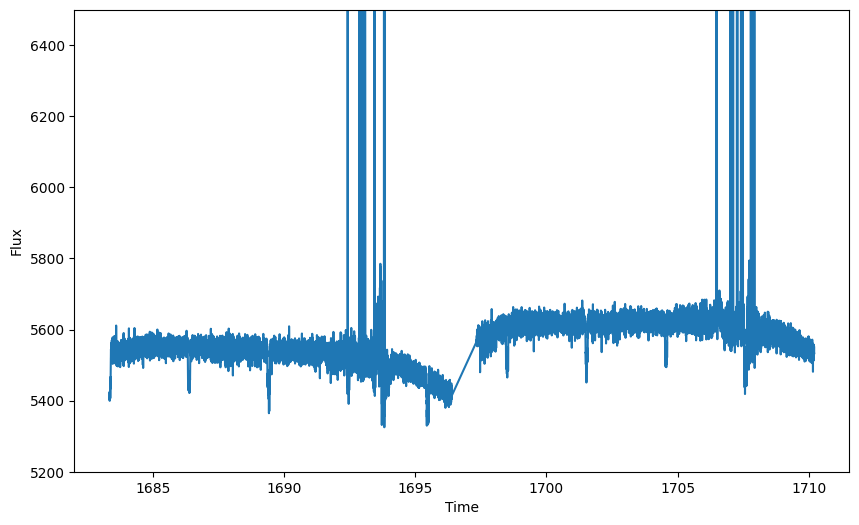

In [4]:
# Give your planet name - be sure to spell everything exactly right. Otherwise, the package won't find the data. Done
planet_name = "TrES-1"

orbital_period = 3.03007 # Oribtal period for TrES-1:
#https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS
#Done


time, flux = get_planet_lightcurve(planet_name)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(time, flux)

x_label_text = "Time" # Label your x-axis: Done
y_label_text = "Flux" # Label your y-axis: Done
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)

plt.ylim((5200,6500)) # Makes transit data more obvious

# Save your figure - use another name that describes the data plotted: Done
flux_time_plt = "figure1.png"
fig.savefig(flux_time_plt, dpi=300, bbox_inches="tight")

In [5]:
# Calculate the derivative
df = np.diff(flux)
num_sigma = 2.

# Calculate the median value
med = np.median(df)
# Calculate the standard deviation
std = mad(df)

# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111)

# Make a histogram showing the distribution of derivative values.
# ax.hist(df, bins='auto');
# ax.set_yscale('log') # Make it easier to the outliers

# # Add in lines showing the expected width of the distribution if it were just Gaussian.
# ax.axvline(med, lw=3, color='orange')
# ax.axvline(med - num_sigma*std, lw=3, color='orange', ls='--')
# ax.axvline(med + num_sigma*std, lw=3, color='orange', ls='--')

# ax.set_xlim([1*num_sigma*std + med, 1*num_sigma*std + med]) ## Manipulates the range of standard deviations we want to keep

# x_label_text = "Flux Derivatives" # Label your x-axis: Done
# y_label_text = "Bins(Log-Scale)" # Label your y-axis
# ax.set_xlabel(x_label_text)
# ax.set_ylabel(y_label_text)

# # Save your figure - use another name that describes the data plotted
# flux_deriv_distribution = "figure.png"
# fig.savefig(flux_deriv_distribution, dpi=300, bbox_inches="tight")

/usr/local/lib/python3.10/dist-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


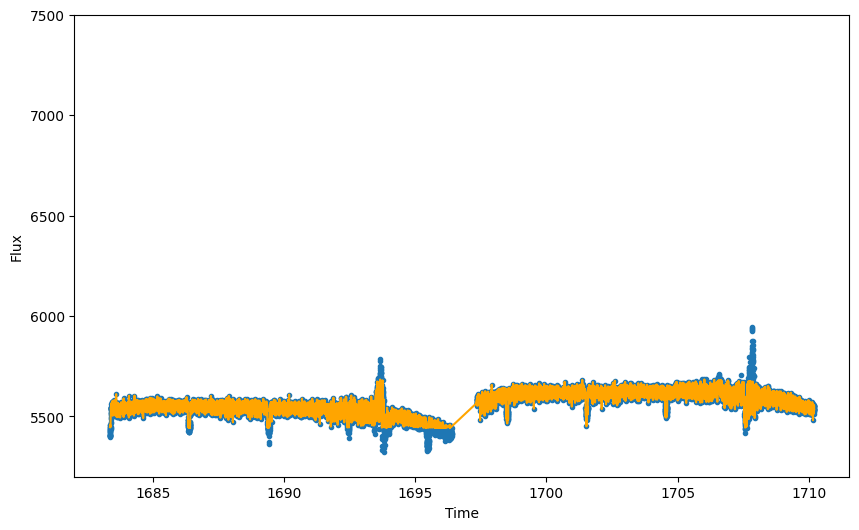

In [6]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# Let's compare the original data with outliers to the processed data with outliers removed.
time, flux = get_planet_lightcurve(planet_name)
ax.plot(time, flux, marker='.', ls='')

# Find the outlier points

# Since your outlier points are SUCH big outliers, we don't need to use the derivative and can just use the data themselves to find outliers.
# df = np.diff(flux)
# ind = np.abs(df - med) > num_sigma*std

med = np.median(flux)
std = mad(flux, scale='normal')
ind = np.abs(flux - med) > num_sigma*std

# Append one extra element - we have to re-jigger the data a bit since diff returns one fewer element.
time = time[~ind]
flux = flux[~ind]
ax.plot(time, flux, color='orange')

x_label_text = "Time" # Label your x-axis: Done
y_label_text = "Flux" # Label your y-axis: Done
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)


plt.ylim((5200,7500)) ## Makes transit data more apparent


# Save your figure - use another name that describes the data plotted: Done
flux_time_plt_2 = "figure2.png"
fig.savefig(flux_time_plt_2, dpi=300, bbox_inches="tight")

per point uncertainty 0.0033513310094177022


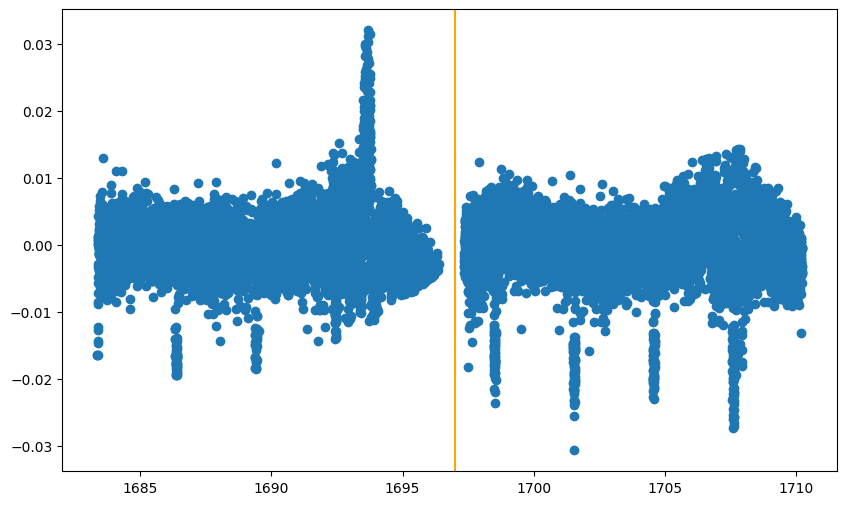

In [7]:
# Because there is a big gap in your data, let's break it into two pieces to detrend.

num_sigma = 3.
polynomial_degree = 2

# We'll leave the transits in.
# med = np.median(flux)
# std = mad(flux)
# ind = (med - flux) > num_sigma*std

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# ax.plot(time, flux, label="original data")
# plt.plot(time[ind], flux[ind], ls='', marker='.', label="in-transit data")

# Fit a polynomial
# coeffs = np.polyfit(time[~ind], flux[~ind], polynomial_degree)

ax.axvline(1697, color='orange')

ind = time < 1697
coeffs = np.polyfit(time[ind], flux[ind], polynomial_degree)
# ax.plot(time[ind], np.polyval(coeffs, time[ind]), color='orange', label="background trend")
detrended_flux = calc_detrended_flux(time[ind], flux[ind], coeffs)

ind = time > 1697
coeffs = np.polyfit(time[ind], flux[ind], polynomial_degree)
# ax.plot(time[ind], np.polyval(coeffs, time[ind]), color='orange', label="background trend")
detrended_flux = np.append(detrended_flux, calc_detrended_flux(time[ind], flux[ind], coeffs))

ax.scatter(time, detrended_flux)

# x_label_text = "Time" # Label your x-axis: Done
# y_label_text = "" # Label your y-axis
# ax.set_xlabel(x_label_text)
# ax.set_ylabel(y_label_text)

# plt.ylim((5200,7500)) ## Makes transit data more apparent


x_label_text = "Time" # Label your x-axis: Done
y_label_text = "Flux" # Label your y-axis: Done


# # Save your figure - use another name that describes the data plotted
level_data = "figure3.png"
fig.savefig(level_data, dpi=300, bbox_inches="tight")



median1 = np.median(detrended_flux)
MAD1 = np.median(np.abs(detrended_flux - median1))
uncertainty = MAD1 * 1.4826
print("per point uncertainty", uncertainty)

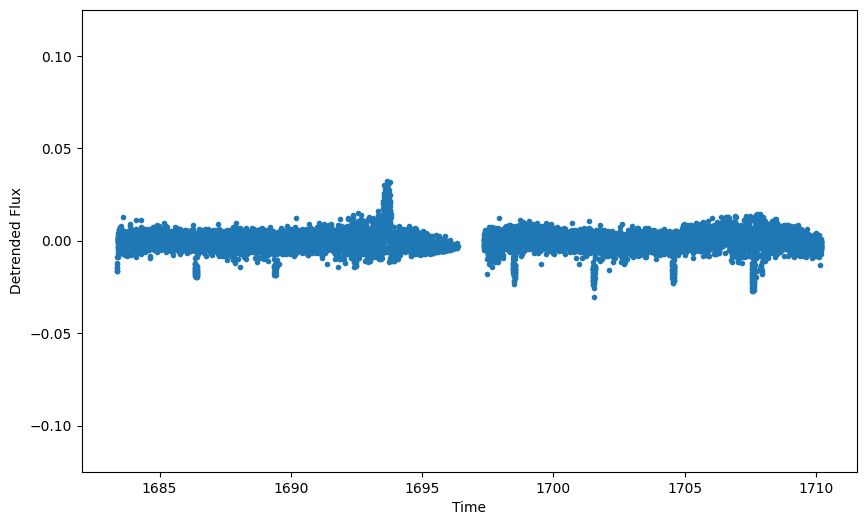

In [8]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# And now let's plot the detrended/outlier-filtered data
ax.scatter(time, detrended_flux, marker='.')

x_label_text = "Time" # Label your x-axis: Done
y_label_text = "Detrended Flux" # Label your y-axis: Done
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)

plt.ylim((-.125,.125)) ## Makes transit data more apparent


# Save your figure - use another name that describes the data plotted
detrended_flux_time_plt = "figure4.png"
fig.savefig(detrended_flux_time_plt, dpi=300, bbox_inches="tight")

(-0.125, 0.125)

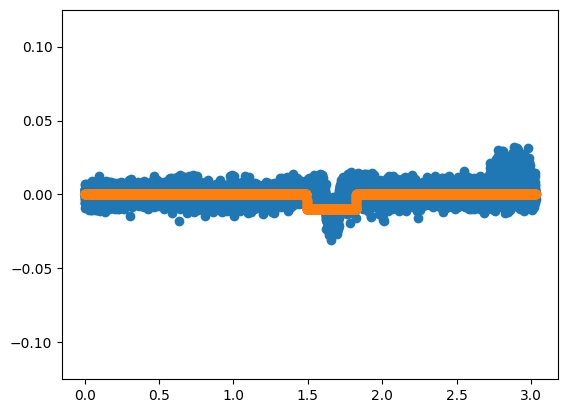

In [9]:
# Phase-folded time
folded_time = (time % orbital_period)
# Detrend the flux
# detrended_flux = calc_detrended_flux(time, flux, coeffs)

# The background value is very nearly the median for all the data
background = np.median(detrended_flux)

# ratio of the planet's to the star's radius - usually about 0.1
ratio_of_planet_to_star_radius = 0.1

# Let's guess that the central transit time is the time when the flux drops to its minimum value
t0 = (time % orbital_period)[np.argmin(detrended_flux)]

# transit duration - probably a few hours, but be sure to tweak it to what your eyeball says
duration = 4./24. # Divide through 24 hours to convert from hours to days.

# Let's set our initial guesses and check them
initial_guesses = np.array([t0, background, ratio_of_planet_to_star_radius**2,
                            2.*duration, 2.*duration*ratio_of_planet_to_star_radius**2])

plt.scatter(folded_time, detrended_flux)
plt.scatter(folded_time, Carter_model(folded_time, *initial_guesses))

detrended_flux_folded_time = "figure5.png"
fig.savefig(detrended_flux_folded_time, dpi=300, bbox_inches="tight")


x_label_text = "Time" # Label your x-axis: Done
y_label_text = "Flux" # Label your y-axis: Done

plt.ylim((-.125,.125)) ## Makes transit data more apparent


best fit values: 1.66469, 0.000365568, 0.0169798, 0.088256, 0.0137516
best fit uncertainties: 0.000262166, 2.95402e-05, 0.000221211, 0.000556345, 0.00092549


(-0.125, 0.125)

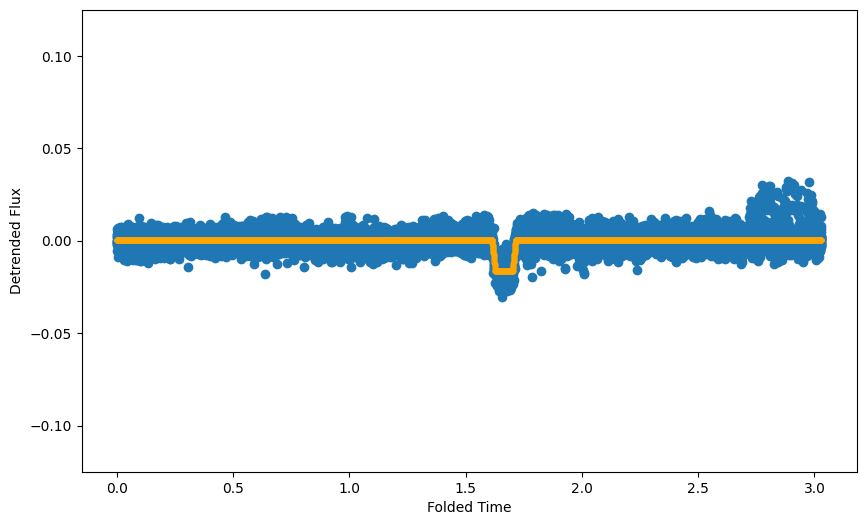

In [10]:
# Reset initial guesses
initial_guesses = np.array([t0, background, ratio_of_planet_to_star_radius,
                            2.*duration, 2.*duration*ratio_of_planet_to_star_radius**2])

# Estimate per-point uncertainties
sigma = calc_sigma(detrended_flux)

# Fit folded transit
transit_shape_params, pcov = curve_fit(Carter_model, folded_time, detrended_flux,
                      p0=initial_guesses, sigma=sigma)
transit_shape_params_unc = np.sqrt(np.diag(pcov))
print("best fit values: %g, %g, %g, %g, %g" %\
      (transit_shape_params[0],
       transit_shape_params[1],
       transit_shape_params[2],
       transit_shape_params[3],
       transit_shape_params[4]))
print("best fit uncertainties: %g, %g, %g, %g, %g" % (transit_shape_params_unc[0],
                                                      transit_shape_params_unc[1],
                                                      transit_shape_params_unc[2],
                                                      transit_shape_params_unc[3],
                                                      transit_shape_params_unc[4]))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# Check the fit
ax.scatter(folded_time, detrended_flux)
ax.scatter(folded_time, Carter_model(folded_time, *transit_shape_params), marker='.', color='orange')

x_label_text = "Folded Time" # Label your x-axis: Done
y_label_text = "Detrended Flux" # Label your y-axis
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)

# Save your figure - use another name that describes the data plotted
detrended_flux_folded_time_plt = "figure6.png"
fig.savefig(detrended_flux_folded_time_plt, dpi=300, bbox_inches="tight")

plt.ylim((-.125,.125)) ## Makes transit data more apparent


(-0.125, 0.125)

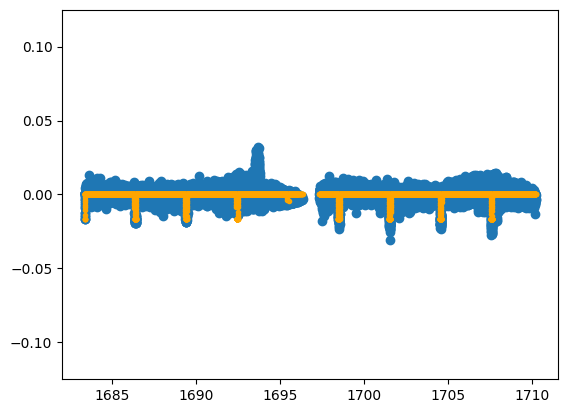

In [11]:
# Again let's set our initial guesses and check how they look
T0 = 0.5*transit_shape_params[0] # This number has to be VERY close to the right number.
ephemeris_initial_guesses = np.array([T0, orbital_period])
initial_guess_transits = fit_transit_ephemeris(time, *ephemeris_initial_guesses)

plt.scatter(time, detrended_flux)
plt.scatter(time, initial_guess_transits, color='orange', marker='.')

transit_guess = "figure7.png"
fig.savefig(transit_guess, dpi=300, bbox_inches="tight")

x_label_text = "Detrended Time" # Label your x-axis: Done
y_label_text = "Folded Flux" # Label your y-axis: Done

plt.ylim((-.125,.125)) ## Makes transit data more apparent


[0.83234678 3.03007   ]
best fit T0, period: 0.831319, 3.03007
best fit T0, period unc: 0.028552, 0.000102089


(-0.125, 0.125)

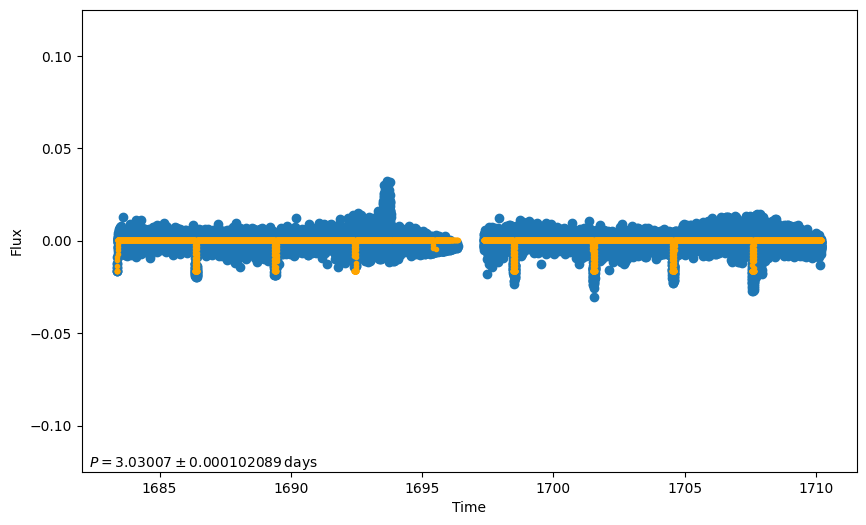

In [12]:
# Now let's do our fit.

ephemeris_fit_params, pcov = curve_fit(fit_transit_ephemeris, time, detrended_flux,
                       p0=ephemeris_initial_guesses, sigma=sigma)
ephemeris_fit_params_unc = np.sqrt(np.diag(pcov))
print(ephemeris_initial_guesses)
print("best fit T0, period: %g, %g" % (ephemeris_fit_params[0], ephemeris_fit_params[1]))
print("best fit T0, period unc: %g, %g" % (ephemeris_fit_params_unc[0], ephemeris_fit_params_unc[1]))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.scatter(time, detrended_flux)
ax.scatter(time, fit_transit_ephemeris(time, *ephemeris_fit_params), color='orange', marker='.')

# Include your final result on the figure
ax.text(0.01, 0.01, r'$P = %g\pm%g\,{\rm days}$' % (ephemeris_fit_params[1], ephemeris_fit_params_unc[1]),
        transform=ax.transAxes)


x_label_text = "Time" # Label your x-axis: Done
y_label_text = "Flux" # Label your y-axis: Done
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)

# Save your figure - use another name that describes the data plotted
transit_fit = "figure8.png"
fig.savefig(transit_fit, dpi=300, bbox_inches="tight")

plt.ylim((-.125,.125)) ## Makes transit data more apparent



